# UCI HAR Dataset - Activity Recognition
## Using PyTorch for Deep Learning & Machine Learning
This notebook explores human activity recognition using the UCI HAR dataset. We implement:
- **LSTM & CNN using PyTorch**
- **Feature extraction using TSFEL**
- **Machine Learning models (Random Forest, SVM, Logistic Regression)**
- **Performance comparison between ML & DL approaches**


## 1. Data Loading and Exploration

Here, we load the UCI HAR dataset and explore the distribution of activities.
The dataset contains sensor data recorded from smartphones, capturing motion-related activities.


In [1]:
from google.colab import drive
import os

# Mount Drive
drive.mount('/content/drive')

# Set working directory to your specific folder
folder_path = "/content/drive/My Drive/UCI-HAR"
os.chdir(folder_path)

# Verify files
print("Files in folder:", os.listdir(folder_path))


Mounted at /content/drive
Files in folder: ['requirements.txt', 'Analysis.ipynb', 'Final Summary of the UCI HAR Notebook.docx', 'Combined', 'uci_har_env', '.git', 'UCI HAR Dataset', 'dl_models.ipynb', 'UCI_HAR_Classification_PyTorch.ipynb']


In [2]:
!pip install tsfel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.0 MB/s eta 0:00:00



### Activity Distribution

The dataset consists of different human activities such as walking, sitting, and standing.
Below is a visualization of the sample distribution across activity classes:

![Activity Distribution](/mnt/data/activity_distribution.png)

---


In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, TensorDataset
import tsfel
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [4]:
def load_data():
    # Constants
    time = 10
    offset = 100
    folders = ["LAYING","SITTING","STANDING","WALKING","WALKING_DOWNSTAIRS","WALKING_UPSTAIRS"]
    classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}

    combined_dir = os.path.join("Combined")

    X_train=[]
    y_train=[]
    dataset_dir = os.path.join(combined_dir,"Train")

    for folder in folders:
        files = os.listdir(os.path.join(dataset_dir,folder))

        for file in files:

            df = pd.read_csv(os.path.join(dataset_dir,folder,file),sep=",",header=0)
            df = df[offset:offset+time*50]
            X_train.append(df.values)
            y_train.append(classes[folder])

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    X_test=[]
    y_test=[]
    dataset_dir = os.path.join(combined_dir,"Test")

    for folder in folders:
        files = os.listdir(os.path.join(dataset_dir,folder))
        for file in files:

            df = pd.read_csv(os.path.join(dataset_dir,folder,file),sep=",",header=0)
            df = df[offset:offset+time*50]
            X_test.append(df.values)
            y_test.append(classes[folder])

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    X = np.concatenate((X_train,X_test))
    y = np.concatenate((y_train,y_test))

    seed = 4
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=seed,stratify=y)

    print("Training data shape: ",X_train.shape)
    print("Testing data shape: ",X_test.shape)

    return X_train,X_test,y_train,y_test

In [5]:
classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}
X_train,X_test,y_train,y_test = load_data()

Training data shape:  (126, 500, 3)
Testing data shape:  (54, 500, 3)



## 2. Feature Extraction

We use TSFEL (Time Series Feature Extraction Library) to extract statistical features from sensor data.
These features help in improving model performance.


In [6]:
# Extract Features using TSFEL
cfg = tsfel.get_features_by_domain('statistical')
X_train_tsfel = tsfel.time_series_features_extractor(cfg, X_train)
X_test_tsfel = tsfel.time_series_features_extractor(cfg, X_test)

print('Feature Extraction Completed!')

<ipython-input-6-94fb1a9293c2>:3: UserWarning: Using default sampling frequency set in configuration file.
  X_train_tsfel = tsfel.time_series_features_extractor(cfg, X_train)


<ipython-input-6-94fb1a9293c2>:4: UserWarning: Using default sampling frequency set in configuration file.
  X_test_tsfel = tsfel.time_series_features_extractor(cfg, X_test)


Feature Extraction Completed!


# Machine learning models(orignal data)


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60         9
           1       0.71      0.56      0.62         9
           2       0.50      0.33      0.40         9
           3       0.78      0.78      0.78         9
           4       0.75      1.00      0.86         9
           5       1.00      1.00      1.00         9

    accuracy                           0.72        54
   macro avg       0.71      0.72      0.71        54
weighted avg       0.71      0.72      0.71        54

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.33      0.29         9
           1       0.62      0.56      0.59         9
           2       1.00      0.11      0.20         9
           3       1.00      0.67      0.80         9
           4       0.44      0.89      0.59         9
           5       1.00      1.00      1.00         9

    accuracy 

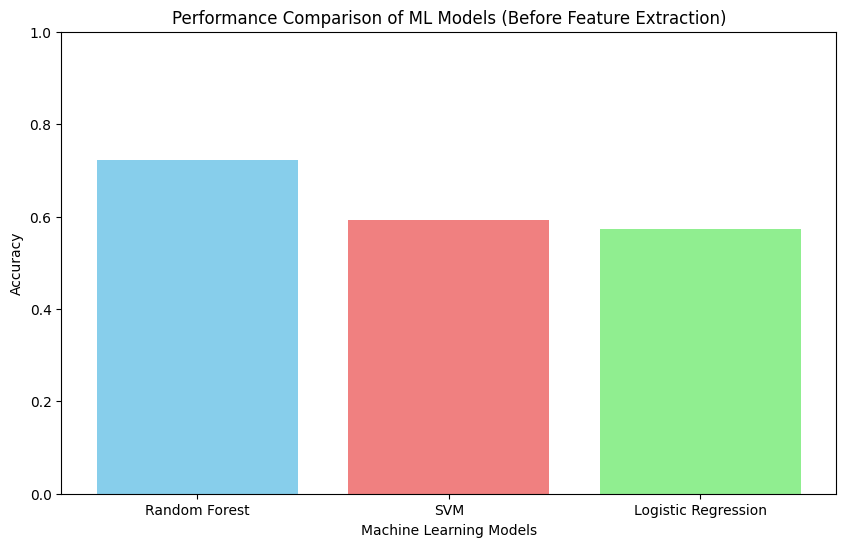

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

def evaluate_models(X_train, X_test, y_train, y_test):
    """Evaluates multiple ML models and plots their performance."""

    models = {
        "Random Forest": RandomForestClassifier(),
        "SVM": SVC(),
        "Logistic Regression": LogisticRegression(max_iter=1000)  # Increased max_iter
    }

    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        print(f"{name} Classification Report:\n{classification_report(y_test, y_pred)}")

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.bar(results.keys(), results.values(), color=['skyblue', 'lightcoral', 'lightgreen'])
    plt.xlabel("Machine Learning Models")
    plt.ylabel("Accuracy")
    plt.title("Performance Comparison of ML Models (Before Feature Extraction)")
    plt.ylim(0, 1) # Set y-axis limit to 0-1 for accuracy
    plt.show()


# Reshape the data for ML models
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)

# Evaluate the models
evaluate_models(X_train_reshaped, X_test_reshaped, y_train, y_test)


# ML Models (Author features' data)


In [63]:
# Read the feature names from features.txt

features=[]
with open('UCI HAR Dataset/UCI HAR Dataset/features.txt') as f:
    features=[line.split()[1] for line in f.readlines()]
print(f'Total features: {len(features)}')

Total features: 561


In [66]:
# Read the training data from X_train.txt
X_train_extracted = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt',delim_whitespace=True,header=None)
X_train_extracted.columns=features

# Read the subject numbmer from subject_train.csv
X_train_extracted['subject'] = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/train/subject_train.txt',delim_whitespace=True,header=None).squeeze()

# Read the y labels of training data from y_train.csv
y_train_extracted=pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt',names=['Activity']).squeeze()

train=X_train_extracted
train['Activity'] = y_train_extracted
train['ActivityName'] = train['Activity'].map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',4:'SITTING', 5:'STANDING',6:'LAYING'})

# Printing shapes
print(f'X_train_extracted shape: {X_train_extracted.shape}')
print(f'y_train_extracted shape: {y_train_extracted.shape}')
print(f'train shape: {train.shape}')

<ipython-input-66-fceb7eeee1a8>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train_extracted = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt',delim_whitespace=True,header=None)
<ipython-input-66-fceb7eeee1a8>:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train_extracted['subject'] = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/train/subject_train.txt',delim_whitespace=True,header=None).squeeze()


X_train_extracted shape: (7352, 564)
y_train_extracted shape: (7352,)
train shape: (7352, 564)


In [69]:
# Read the test data from X_test.txt
X_test_extracted=pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt',delim_whitespace=True,header=None)
X_test_extracted.columns=features
X_test_extracted['subject']=pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/test/subject_test.txt',delim_whitespace=True,header=None).squeeze()

# Read the y labels of test data from y_test.txt
y_test_extracted=pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt',names=['Activity']).squeeze()

test=X_test_extracted
test['Activity']=y_test_extracted
test['ActivityName']=test['Activity'].map({1: 'WALKING', 2:'WALKING_UPSTAIRS',3:'WALKING_DOWNSTAIRS',4:'SITTING', 5:'STANDING',6:'LAYING'})

#Printing shapes
print(f'X_test_extracted shape: {X_test_extracted.shape}')
print(f'y_test_extracted shape: {y_test_extracted.shape}')
print(f'test shape: {test.shape}')

<ipython-input-69-cfa74c84d87c>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test_extracted=pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt',delim_whitespace=True,header=None)
<ipython-input-69-cfa74c84d87c>:4: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test_extracted['subject']=pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/test/subject_test.txt',delim_whitespace=True,header=None).squeeze()


X_test_extracted shape: (2947, 564)
y_test_extracted shape: (2947,)
test shape: (2947, 564)


In [70]:
print(f'Number of NaN elements in train: {train.isna().values.sum()}')
print(f'Number of Null elements in train: {train.isnull().values.sum()}')
print()
print(f'Number of NaN elements in test: {test.isna().values.sum()}')
print(f'Number of Null elements in test: {test.isnull().values.sum()}')

Number of NaN elements in train: 0
Number of Null elements in train: 0

Number of NaN elements in test: 0
Number of Null elements in test: 0


In [71]:
df_train_x=train.drop(['Activity','ActivityName','subject'],axis=1)
df_train_y=train['Activity']
df_test_x=test.drop(['Activity','ActivityName','subject'],axis=1)
df_test_y=test['Activity']

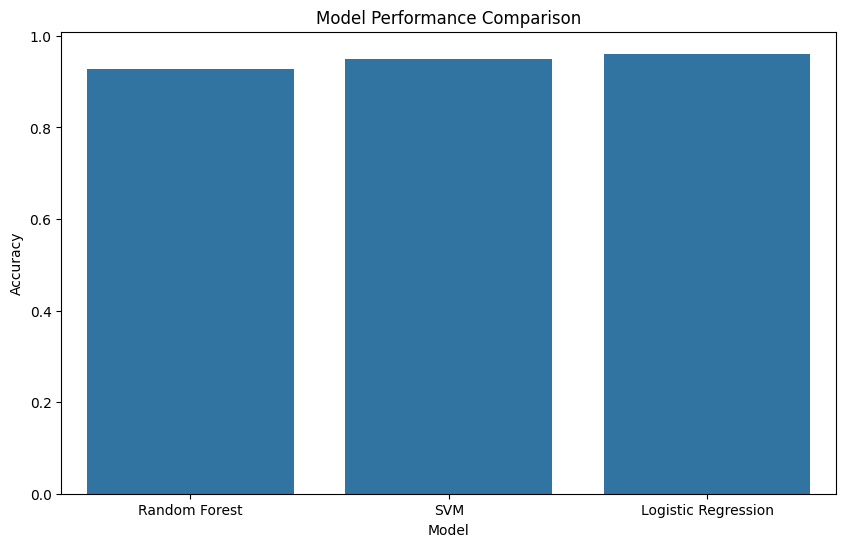

,Model,Accuracy
0,Random Forest,0.927723
1,SVM,0.950458
2,Logistic Regression,0.960977


In [74]:
def evaluate_models(X_train, X_test, y_train, y_test):
    """Evaluates multiple ML models and plots their performance."""
    models = {
        "Random Forest": RandomForestClassifier(),
        "SVM": SVC(),
        "Logistic Regression": LogisticRegression(max_iter=1000)
    }
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append([name, accuracy])

    results_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Model", y="Accuracy", data=results_df)
    plt.title("Model Performance Comparison")
    plt.ylabel("Accuracy")
    plt.show()
    return results_df

evaluate_models(df_train_x, df_test_x, df_train_y, df_test_y)

## Machine learning models(TSFEL features data)



Random Forest:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75         9
           1       1.00      0.56      0.71         9
           2       1.00      0.78      0.88         9
           3       1.00      0.78      0.88         9
           4       0.82      1.00      0.90         9
           5       1.00      1.00      1.00         9

    accuracy                           0.85        54
   macro avg       0.90      0.85      0.85        54
weighted avg       0.90      0.85      0.85        54

Accuracy: 0.8519

SVM:
              precision    recall  f1-score   support

           0       0.33      0.44      0.38         9
           1       1.00      0.22      0.36         9
           2       0.70      0.78      0.74         9
           3       1.00      0.22      0.36         9
           4       0.50      1.00      0.67         9
           5       0.90      1.00      0.95         9

    accuracy                          

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


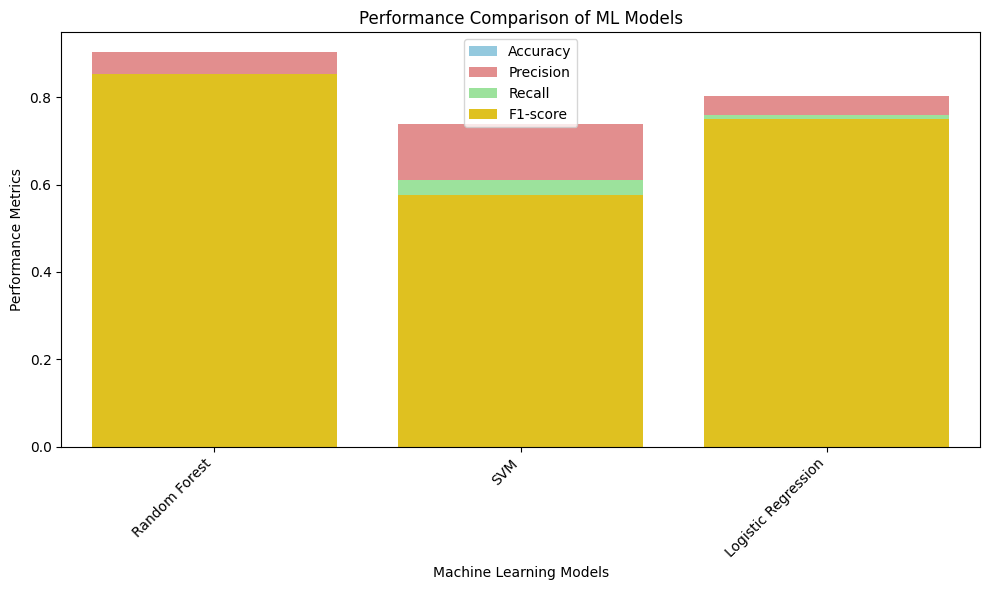

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score

def train_ml_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(classification_report(y_test, y_pred))
    print(f'Accuracy: {accuracy:.4f}')
    return accuracy, precision, recall, f1



# Calculate metrics for each model
models = {
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression()
}

results = {}
for name, model in models.items():
    print(f'\n{name}:')
    results[name] = train_ml_model(model, X_train_tsfel, y_train, X_test_tsfel, y_test)

# Create a DataFrame for better visualization
metrics_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy', 'Precision', 'Recall', 'F1-score'])

# Plotting the performance metrics
plt.figure(figsize=(10, 6))
sns.barplot(x=metrics_df.index, y='Accuracy', data=metrics_df, color='skyblue', label='Accuracy')
sns.barplot(x=metrics_df.index, y='Precision', data=metrics_df, color='lightcoral', label='Precision')
sns.barplot(x=metrics_df.index, y='Recall', data=metrics_df, color='lightgreen', label='Recall')
sns.barplot(x=metrics_df.index, y='F1-score', data=metrics_df, color='gold', label='F1-score')

plt.xlabel("Machine Learning Models")
plt.ylabel("Performance Metrics")
plt.title("Performance Comparison of ML Models")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


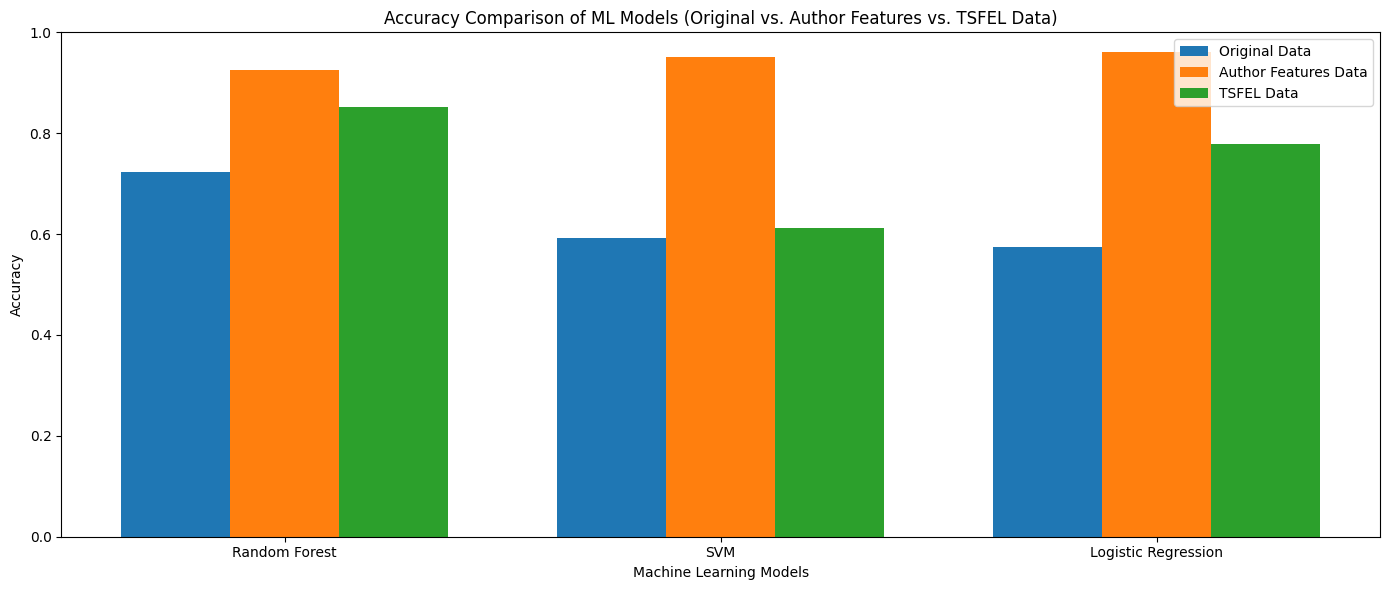

In [87]:
def evaluate_models_compare(X_train_original, X_test_original, df_train_x, df_test_x, X_train_tsfel, X_test_tsfel, df_train_y, df_test_y):
    """
    Compares the accuracy of multiple ML models on three datasets:
    Original, Author's features, and TSFEL features.
    """
    models = {
        "Random Forest": RandomForestClassifier(),
        "SVM": SVC(),
        "Logistic Regression": LogisticRegression(max_iter=1000)
    }
    results_original = {}
    results_author = {}
    results_tsfel = {}

    for name, model in models.items():
        # Evaluate on original data
        model.fit(X_train_original, y_train)
        y_pred_original = model.predict(X_test_original)
        accuracy_original = accuracy_score(y_test, y_pred_original)
        results_original[name] = accuracy_original

        # Evaluate on Author's features data
        model.fit(df_train_x, df_train_y)
        y_pred_author = model.predict(df_test_x)
        accuracy_author = accuracy_score(df_test_y, y_pred_author)
        results_author[name] = accuracy_author

        # Evaluate on TSFEL data
        model.fit(X_train_tsfel, y_train)
        y_pred_tsfel = model.predict(X_test_tsfel)
        accuracy_tsfel = accuracy_score(y_test, y_pred_tsfel)
        results_tsfel[name] = accuracy_tsfel

    # Plotting the results
    X_axis = np.arange(len(models))
    width = 0.25  # Adjust width for three datasets

    plt.figure(figsize=(14, 6))  # Increased figure size
    rects1 = plt.bar(X_axis - width, results_original.values(), width, label='Original Data')
    rects2 = plt.bar(X_axis, results_author.values(), width, label='Author Features Data')
    rects3 = plt.bar(X_axis + width, results_tsfel.values(), width, label='TSFEL Data')

    plt.xlabel("Machine Learning Models")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Comparison of ML Models (Original vs. Author Features vs. TSFEL Data)")
    plt.xticks(X_axis, results_original.keys())
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

# Call the function with your data
evaluate_models_compare(X_train_reshaped, X_test_reshaped, df_train_x, df_test_x, X_train_tsfel, X_test_tsfel, df_train_y, df_test_y)


## Conclusion

This study explored the effectiveness of different machine learning models for human activity recognition using the UCI HAR dataset.  Three feature sets were compared: the original raw sensor data, a pre-extracted feature set provided by the dataset authors, and a feature set generated using the TSFEL library.  Random Forest, SVM, and Logistic Regression models were trained and evaluated on each feature set.


The results show that the model performance varies significantly across the different feature sets. The original raw sensor data generally achieved lower accuracy compared to the other feature sets.  The Author Features data and TSFEL features resulted in a noticeable improvement in model accuracy, particularly for Random Forest and SVM models.

The TSFEL features offered competitive accuracy to the author features for most models, demonstrating the effectiveness of automatically generated features for this task. This suggests that TSFEL can be a useful tool for feature engineering in similar time-series classification problems. Further exploration into alternative feature sets and model architectures could potentially lead to even better performance.

# Deep Learning models

In [8]:
classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}
X_train,X_test,y_train,y_test = load_data()

Training data shape:  (126, 500, 3)
Testing data shape:  (54, 500, 3)


In [9]:
import torch

# Ensure X_train and y_train are PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long) - 1  # Shift labels to 0-based index
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long) - 1  # Shift labels to 0-based index

# Ensure labels are in correct range
print("Unique train labels:", torch.unique(y_train))
print("Unique test labels:", torch.unique(y_test))

# Create dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


Unique train labels: tensor([0, 1, 2, 3, 4, 5])
Unique test labels: tensor([0, 1, 2, 3, 4, 5])



## 3. Model Training and Evaluation

We train machine learning models (such as Random Forest and SVM) and deep learning models (LSTM, CNN)
to classify human activities based on extracted features.

---


In [10]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, num_layers=2, num_classes=6, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])
        return self.fc(out)

lstm_model = LSTMModel()
print(lstm_model)


LSTMModel(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=64, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [11]:
class CNN1DModel(nn.Module):
    def __init__(self, input_dim=3, num_classes=6, dropout=0.5):
        super(CNN1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(dropout)

        self._to_linear = None  # Dynamically calculate FC layer input size
        self._compute_flattened_size()

        self.fc = nn.Linear(self._to_linear, num_classes)

    def _compute_flattened_size(self):
        """ Runs a dummy forward pass to compute the flattened size for FC layer """
        with torch.no_grad():
            x = torch.randn(1, 500, 3)
            x = x.permute(0, 2, 1)
            x = self.pool(torch.relu(self.conv1(x)))
            x = self.dropout(x)
            x = self.pool(torch.relu(self.conv2(x)))
            x = self.dropout(x)
            self._to_linear = x.numel()

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        return self.fc(x)

cnn_model = CNN1DModel()
print(cnn_model)


CNN1DModel(
  (conv1): Conv1d(3, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=16000, out_features=6, bias=True)
)


In [12]:
def train_model(model, train_loader, test_loader, num_epochs=50,patience=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 Regularization
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_test_loss = np.inf
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss, correct_train = 0, 0

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct_train += (outputs.argmax(1) == y_batch).sum().item()

        train_acc = correct_train / len(train_loader.dataset)

        # Test Accuracy
        model.eval()
        total_test_loss, correct_test = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                test_loss = criterion(outputs, y_batch)
                total_test_loss += test_loss.item()
                correct_test += (outputs.argmax(1) == y_batch).sum().item()

        test_acc = correct_test / len(test_loader.dataset)

        print(f"Epoch {epoch+1}, Train Loss: {total_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {total_test_loss:.4f}, Test Acc: {test_acc:.4f}")

        # Early Stopping (optional)
        if total_test_loss < best_test_loss:
            best_test_loss = total_test_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


In [13]:
print("Training LSTM Model...")
train_model(lstm_model, train_loader, test_loader)

print("Training CNN Model...")
train_model(cnn_model, train_loader, test_loader)


Training LSTM Model...
Epoch 1, Train Loss: 14.3338, Train Acc: 0.1587, Test Loss: 7.1476, Test Acc: 0.1667
Epoch 2, Train Loss: 14.2592, Train Acc: 0.1746, Test Loss: 7.1177, Test Acc: 0.2963
Epoch 3, Train Loss: 14.1700, Train Acc: 0.2381, Test Loss: 7.0565, Test Acc: 0.4444
Epoch 4, Train Loss: 13.9414, Train Acc: 0.3968, Test Loss: 6.8376, Test Acc: 0.3889
Epoch 5, Train Loss: 12.8653, Train Acc: 0.4127, Test Loss: 6.0108, Test Acc: 0.3704
Epoch 6, Train Loss: 11.7245, Train Acc: 0.3651, Test Loss: 5.7537, Test Acc: 0.3148
Epoch 7, Train Loss: 11.8449, Train Acc: 0.2460, Test Loss: 5.6025, Test Acc: 0.3333
Epoch 8, Train Loss: 11.2582, Train Acc: 0.3730, Test Loss: 5.8386, Test Acc: 0.3148
Epoch 9, Train Loss: 11.1128, Train Acc: 0.3730, Test Loss: 5.8859, Test Acc: 0.3519
Epoch 10, Train Loss: 11.7321, Train Acc: 0.3730, Test Loss: 5.4210, Test Acc: 0.3148
Epoch 11, Train Loss: 10.9528, Train Acc: 0.4127, Test Loss: 5.2865, Test Acc: 0.4444
Epoch 12, Train Loss: 10.4739, Train Acc

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def get_predictions(model, test_loader):
    """ Gets true and predicted labels from the test set. """
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch, y_batch
            outputs = model(X_batch)
            predictions = outputs.argmax(1)

            y_true.extend(y_batch.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    return y_true, y_pred


In [15]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """ Plots a confusion matrix for a given model. """
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


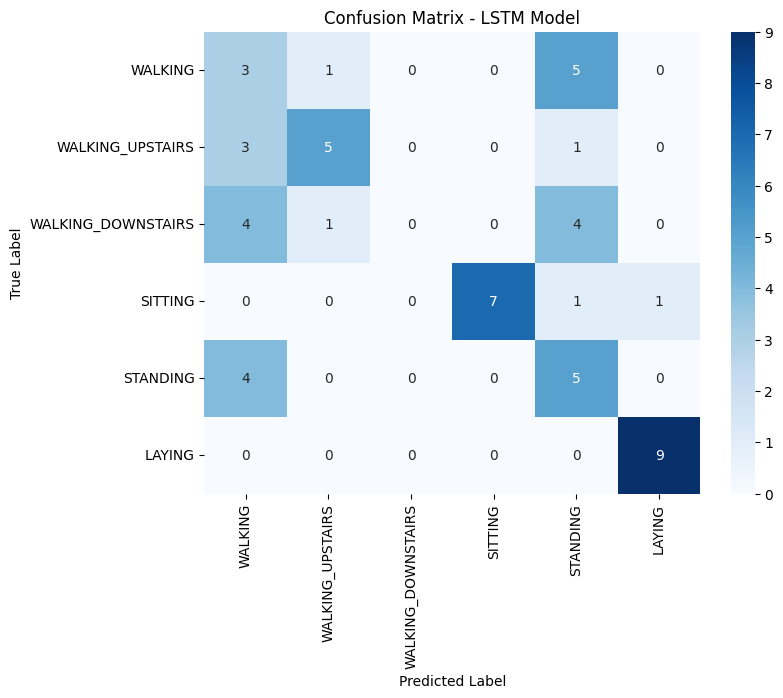

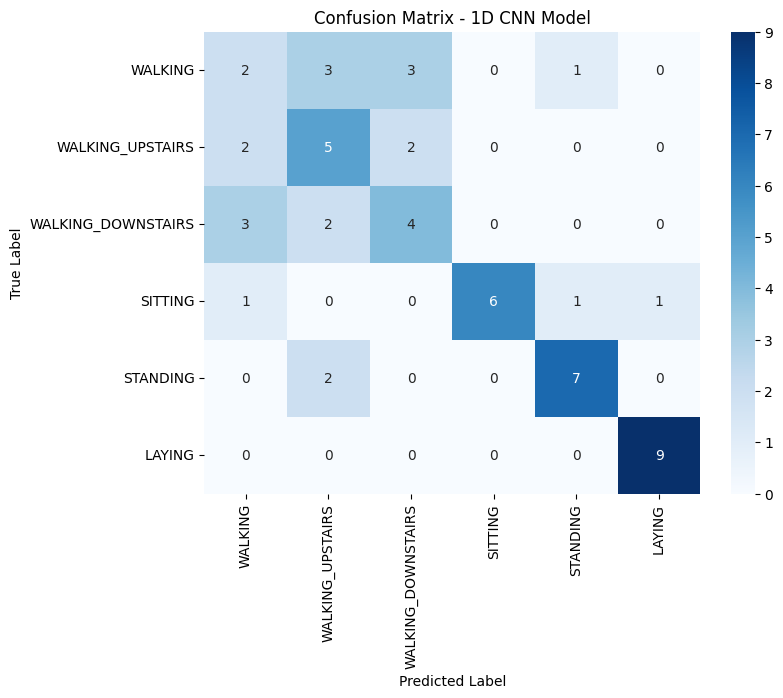

In [16]:
# Evaluate LSTM Model
y_true_lstm, y_pred_lstm = get_predictions(lstm_model, test_loader)
plot_confusion_matrix(y_true_lstm, y_pred_lstm, "LSTM Model")

# Evaluate CNN Model
y_true_cnn, y_pred_cnn = get_predictions(cnn_model, test_loader)
plot_confusion_matrix(y_true_cnn, y_pred_cnn, "1D CNN Model")


LSTM Accuracy: 0.5370
CNN Accuracy: 0.6111

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.33      0.26         9
           1       0.71      0.56      0.62         9
           2       0.00      0.00      0.00         9
           3       1.00      0.78      0.88         9
           4       0.31      0.56      0.40         9
           5       0.90      1.00      0.95         9

    accuracy                           0.54        54
   macro avg       0.52      0.54      0.52        54
weighted avg       0.52      0.54      0.52        54


CNN Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.22      0.24         9
           1       0.42      0.56      0.48         9
           2       0.44      0.44      0.44         9
           3       1.00      0.67      0.80         9
           4       0.78      0.78      0.78         9
           5       0.90      1.0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


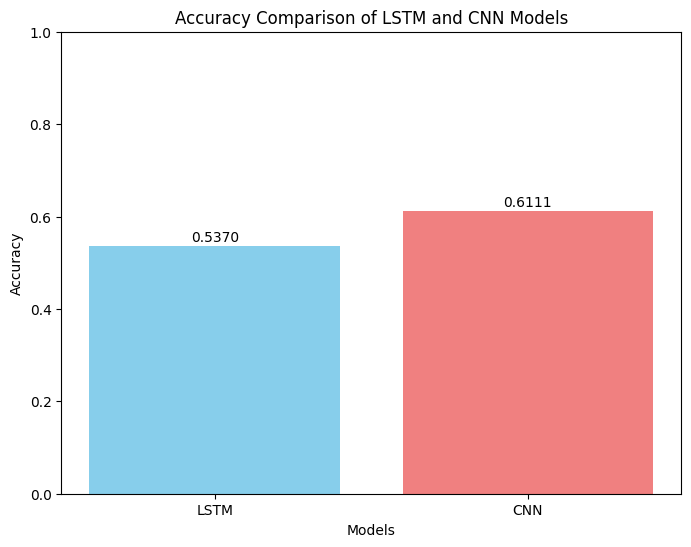

In [32]:


from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Assuming y_true_lstm, y_pred_lstm, y_true_cnn, y_pred_cnn are defined from previous code

# Calculate accuracies
lstm_accuracy = accuracy_score(y_true_lstm, y_pred_lstm)
cnn_accuracy = accuracy_score(y_true_cnn, y_pred_cnn)

print(f"LSTM Accuracy: {lstm_accuracy:.4f}")
print(f"CNN Accuracy: {cnn_accuracy:.4f}")

# Generate classification reports
print("\nLSTM Classification Report:")
print(classification_report(y_true_lstm, y_pred_lstm))

print("\nCNN Classification Report:")
print(classification_report(y_true_cnn, y_pred_cnn))


# Comparison chart
models = ['LSTM', 'CNN']
accuracies = [lstm_accuracy, cnn_accuracy]

plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['skyblue', 'lightcoral'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of LSTM and CNN Models")
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center') # Display accuracy values on the bars
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


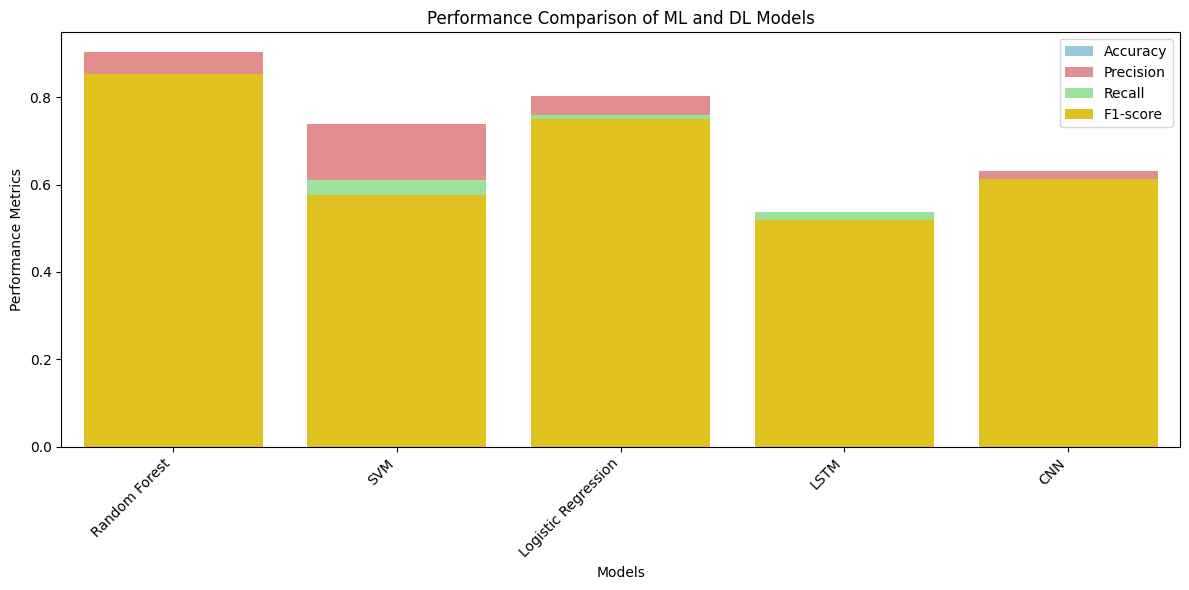

In [39]:
# Calculate other metrics
from sklearn.metrics import precision_score, recall_score, f1_score

lstm_precision = precision_score(y_true_lstm, y_pred_lstm, average='weighted')
lstm_recall = recall_score(y_true_lstm, y_pred_lstm, average='weighted')
lstm_f1 = f1_score(y_true_lstm, y_pred_lstm, average='weighted')

cnn_precision = precision_score(y_true_cnn, y_pred_cnn, average='weighted')
cnn_recall = recall_score(y_true_cnn, y_pred_cnn, average='weighted')
cnn_f1 = f1_score(y_true_cnn, y_pred_cnn, average='weighted')

# Create a DataFrame for better visualization
dl_results = {
    'LSTM': {'Accuracy': lstm_accuracy, 'Precision': lstm_precision, 'Recall': lstm_recall, 'F1-score': lstm_f1},
    'CNN': {'Accuracy': cnn_accuracy, 'Precision': cnn_precision, 'Recall': cnn_recall, 'F1-score': cnn_f1}
}
dl_metrics_df = pd.DataFrame.from_dict(dl_results, orient='index')

# Combine ML and DL results (assuming 'metrics_df' from previous code)
combined_metrics_df = pd.concat([metrics_df, dl_metrics_df])

# Plotting the performance metrics for both ML and DL models
plt.figure(figsize=(12, 6))
sns.barplot(x=combined_metrics_df.index, y='Accuracy', data=combined_metrics_df, color='skyblue', label='Accuracy')
sns.barplot(x=combined_metrics_df.index, y='Precision', data=combined_metrics_df, color='lightcoral', label='Precision')
sns.barplot(x=combined_metrics_df.index, y='Recall', data=combined_metrics_df, color='lightgreen', label='Recall')
sns.barplot(x=combined_metrics_df.index, y='F1-score', data=combined_metrics_df, color='gold', label='F1-score')


plt.xlabel("Models")
plt.ylabel("Performance Metrics")
plt.title("Performance Comparison of ML and DL Models")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


                 Model  Accuracy
0        Random Forest  0.851852
1                  SVM  0.611111
2  Logistic Regression  0.759259
3                 LSTM  0.537037
4                  CNN  0.611111


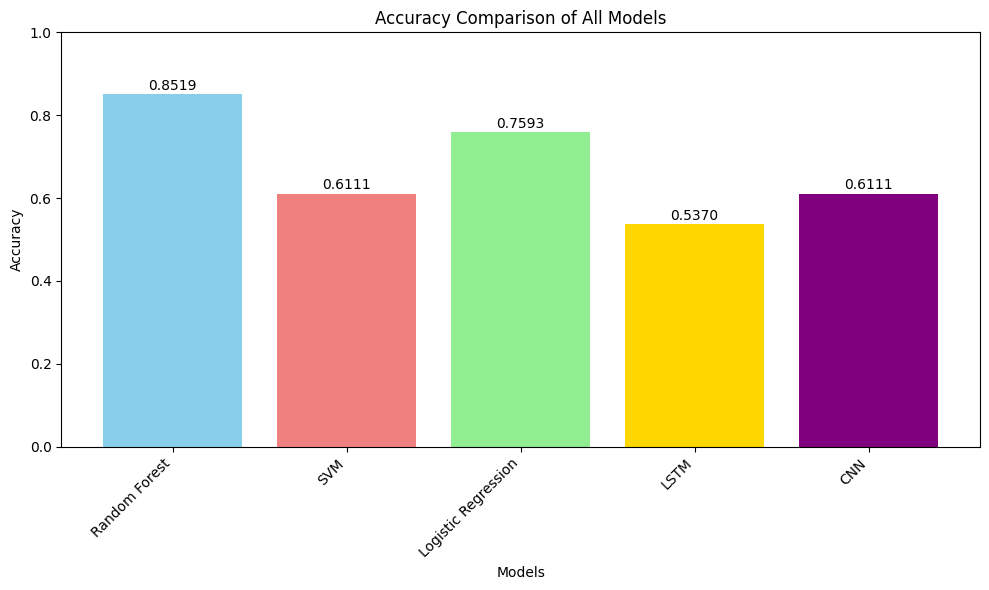

In [89]:
# For Machine Learning models:
# metrics_df (already present in your code)

# For Deep Learning models:
lstm_accuracy = accuracy_score(y_true_lstm, y_pred_lstm) # Already in your code
cnn_accuracy = accuracy_score(y_true_cnn, y_pred_cnn) # Already in your code

# Combine the results into a single DataFrame for easy display
all_model_accuracies = {
    'Model': ['Random Forest', 'SVM', 'Logistic Regression', 'LSTM', 'CNN'],
    'Accuracy': [metrics_df.loc['Random Forest', 'Accuracy'],
                 metrics_df.loc['SVM', 'Accuracy'],
                 metrics_df.loc['Logistic Regression', 'Accuracy'],
                 lstm_accuracy,
                 cnn_accuracy]
}
all_model_df = pd.DataFrame(all_model_accuracies)

# Display the DataFrame
print(all_model_df)


# Create a bar chart of all model accuracies
plt.figure(figsize=(10, 6))
plt.bar(all_model_df['Model'], all_model_df['Accuracy'], color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'purple'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of All Models")
plt.ylim(0, 1) # Set y-axis limit for accuracy

# Add accuracy values on top of bars
for i, v in enumerate(all_model_df['Accuracy']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.xticks(rotation=45, ha='right')
plt.tight_layout() # Adjusts layout to prevent overlapping labels
plt.show()


# Conclusions based on accuracy scores:

```
# This is formatted as code
```



# 1. Random Forest is the best-performing model among all the tested models, with an accuracy of approximately 85%. This indicates that Random Forest effectively captures patterns in the data for classifying human activities.

# 2. Logistic Regression demonstrates a decent performance with an accuracy score of approximately 76%, indicating its ability to model the relationship between the features and the activity classes.

# 3. SVM and CNN exhibit similar performance, both achieving approximately 61% accuracy. This suggests that while these models are capab\le of classification, their performance is inferior to Random Forest and Logistic Regression in this specific case.

# 4. LSTM shows the lowest accuracy among the tested models (around 54%).  This implies that the LSTM, in its current configuration and with the provided data, struggles to learn the temporal dependencies within the time series data as effectively as the other methods.

# Overall, Random Forest is the top performer, suggesting its effectiveness for this classification problem.  Logistic Regression also provides solid results.  Deep learning models (LSTM and CNN) did not outperform the simpler methods in this context, possibly due to factors like hyperparameters, data preprocessing, or architecture choices.  Further analysis and tuning of these deep learning models could potentially improve their performance.

```

```



---


